In [16]:
import numpy as np
import pickle
from matplotlib.animation import FFMpegWriter
import cv2 
import src.utils as utils
import src.stat as stat
from tqdm import tqdm
import src.utils as utils
import matplotlib.pyplot as plt
import glob
import torch

Errors

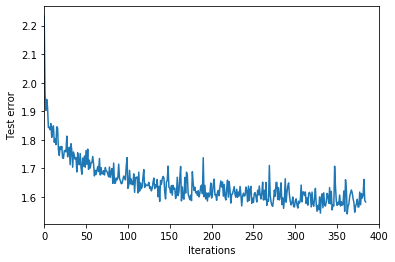

In [3]:
data_dir = '/data/LiftPose3D/mouse_prism'

epoch, lr, loss_train, loss_test, err_test = utils.read_convergence_info(data_dir +'/log_train.txt')
plt.plot(np.array(err_test))
    
plt.xlim([0, 400])
#plt.ylim([0.01,0.03])
plt.ylabel('Test error')
plt.xlabel('Iterations')
plt.savefig('test_error.svg')

In [14]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def undistort(im,idx):
    shape = im.shape
    im_flat = im.flatten('F')
    im_flat = im_flat[idx]
    return np.reshape(im_flat,(shape[0], shape[1]),'F')

def video_to_imgs(vid_path):
    '''Convert video to a list of images'''
    
    cap = cv2.VideoCapture(vid_path)         
    imgs = []            
    while True:
        flag, frame = cap.read()
        if flag:                            
            imgs.append(frame)       
        else:
            break        
    
    return imgs

# Load data

In [15]:
idx = 0

#mousetracker
files = sorted(glob.glob(data_dir + '/*.pkl'))
videos = sorted(glob.glob(data_dir + '/*.avi'))
poses = pickle.load(open(files[idx],'rb'))
index = poses['index']

#LiftPose3D prediction
data = torch.load(data_dir + '/test_results.pth.tar')
tar_mean = torch.load(data_dir + '/stat_3d.pth.tar')['mean']
tar_std = torch.load(data_dir + '/stat_3d.pth.tar')['std']
targets_1d = torch.load(data_dir + '/stat_3d.pth.tar')['targets_1d']
tar_offset = np.vstack(torch.load(data_dir + '/stat_3d.pth.tar')['offset'].values())
good_keypts = utils.add_roots(data['good_keypts'],targets_1d,len(tar_mean)).astype(bool)

inp_mean = torch.load(data_dir + '/stat_2d.pth.tar')['mean']
inp_std = torch.load(data_dir + '/stat_2d.pth.tar')['std']
targets_2d = torch.load(data_dir + '/stat_2d.pth.tar')['targets_2d']
inp_offset = np.vstack(torch.load(data_dir + '/stat_2d.pth.tar')['offset'].values())

tar = stat.unNormalize(data['target'], tar_mean[targets_1d], tar_std[targets_1d])
tar = utils.add_roots(tar,targets_1d,len(tar_mean))
tar += tar_offset
out = stat.unNormalize(data['output'], tar_mean[targets_1d], tar_std[targets_1d])
out = utils.add_roots(out,targets_1d,len(tar_mean))
out += tar_offset
inp = stat.unNormalize(data['input'], inp_mean[targets_2d], inp_std[targets_2d])
inp = utils.add_roots(inp,targets_2d,len(inp_mean))
inp += inp_offset

#images
imgs = video_to_imgs(videos[idx])
imgs = [rgb2gray(im) for im in imgs]
imgs = [undistort(im,poses['distort'].flatten()) for im in imgs]

/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/home/gosztolai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


100%|██████████| 400/400 [00:11<00:00, 34.71it/s]


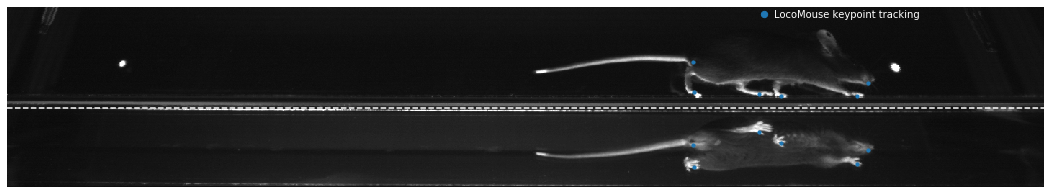

In [18]:
fig = plt.figure(figsize=(15,2.5))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

chosen_keypts = [0,1,2,3,4,5,6]

inp[inp==0]=np.NaN
out[out==0]=np.NaN
tar[tar==0]=np.NaN

bottom_x, bottom_y = inp[:,::2], inp[:,1::2]
side_x, side_y = inp[:,::2], tar
side_x_pred, side_y_pred = inp[:,::2], out

bottom_x, bottom_y = bottom_x[:,chosen_keypts], bottom_y[:,chosen_keypts]
side_x, side_y = side_x[:,chosen_keypts], side_y[:,chosen_keypts]
side_x_pred, side_y_pred = side_x_pred[:,chosen_keypts], side_y_pred[:,chosen_keypts]
good_keypts = good_keypts[:,chosen_keypts]
            
writer = FFMpegWriter(fps=25)
with writer.saving(fig, "video_3.mp4", 100):
    for i in tqdm(range(0,400)):  
        
        plt.cla()

        plt.imshow(imgs[index[i]],cmap='gray', vmin=0, vmax=255)
        plt.axhline(140, color="white", linestyle="--")
        
        plt.scatter(bottom_x[i,good_keypts[i,:]], bottom_y[i,good_keypts[i,:]],s=10,c='C0')
        plt.scatter(side_x[i,good_keypts[i,:]], side_y[i,good_keypts[i,:]],s=10,c='C0')
        #plt.scatter(side_x_pred[i,good_keypts[i,:]], side_y_pred[i,good_keypts[i,:]],s=10,c='C1')
                         
        plt.scatter(1050,10, marker = "o", c='C0', s = 40)
        #plt.scatter(1050,30, marker = "o", c='C1', s = 40)
        plt.text(1065, 15, 'LocoMouse keypoint tracking', fontsize=10, color='white')
        #plt.text(1065, 35, 'LiftPose3D prediction using only the ventral view', fontsize=10, color='white')
        
        #plt.text(120, 80, str(i), fontsize=50, color='white')
        
        plt.axis('off')
        writer.grab_frame()    

Text(1065, 35, 'LiftPose3D prediction using only the ventral view')

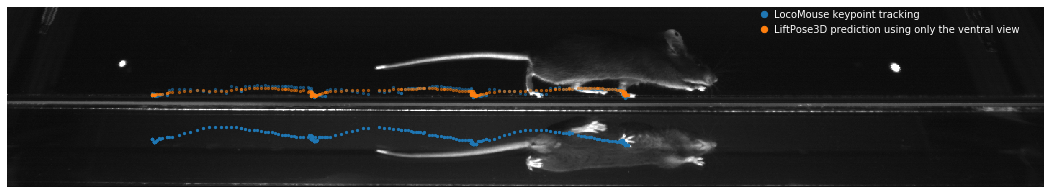

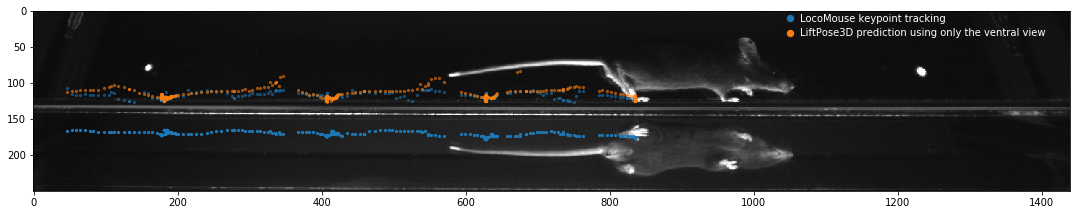

In [39]:
fig = plt.figure(figsize=(15,2.5))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

i=0
chosen_keypts = [2]

inp[inp==0]=np.NaN
out[out==0]=np.NaN
tar[tar==0]=np.NaN

bottom_x, bottom_y = inp[:,::2], inp[:,1::2]
side_x, side_y = inp[:,::2], tar
side_x_pred, side_y_pred = inp[:,::2], out

bottom_x, bottom_y = bottom_x[:,chosen_keypts], bottom_y[:,chosen_keypts]
side_x, side_y = side_x[:,chosen_keypts], side_y[:,chosen_keypts]
side_x_pred, side_y_pred = side_x_pred[:,chosen_keypts], side_y_pred[:,chosen_keypts]

plt.imshow(imgs[index[300]],cmap='gray', vmin=0, vmax=255)
plt.scatter(bottom_x[:300,good_keypts[i,chosen_keypts]], bottom_y[:300,good_keypts[i,chosen_keypts]],s=5,c='C0')
plt.scatter(side_x[:300,good_keypts[i,chosen_keypts]], side_y[:300,good_keypts[i,chosen_keypts]],s=5,c='C0',alpha=0.5)
plt.scatter(side_x_pred[:300,good_keypts[i,chosen_keypts]], side_y_pred[:300,good_keypts[i,chosen_keypts]],s=5,c='C1',alpha=0.5)

plt.scatter(1050,10, marker = "o", c='C0', s = 40)
plt.scatter(1050,30, marker = "o", c='C1', s = 40)
plt.text(1065, 15, 'LocoMouse keypoint tracking', fontsize=10, color='white')
plt.text(1065, 35, 'LiftPose3D prediction using only the ventral view', fontsize=10, color='white')

plt.axis('off')

#plt.savefig('good_paw.svg')

fig = plt.figure(figsize=(15,2.5))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

chosen_keypts = [3]

inp[inp==0]=np.NaN
out[out==0]=np.NaN
tar[tar==0]=np.NaN

bottom_x, bottom_y = inp[:,::2], inp[:,1::2]
side_x, side_y = inp[:,::2], tar
side_x_pred, side_y_pred = inp[:,::2], out

bottom_x, bottom_y = bottom_x[:,chosen_keypts], bottom_y[:,chosen_keypts]
side_x, side_y = side_x[:,chosen_keypts], side_y[:,chosen_keypts]
side_x_pred, side_y_pred = side_x_pred[:,chosen_keypts], side_y_pred[:,chosen_keypts]

plt.imshow(imgs[index[330]],cmap='gray', vmin=0, vmax=255)
plt.scatter(bottom_x[:330,good_keypts[i,chosen_keypts]], bottom_y[:330,good_keypts[i,chosen_keypts]],s=5,c='C0')
plt.scatter(side_x[:330,good_keypts[i,chosen_keypts]], side_y[:330,good_keypts[i,chosen_keypts]],s=5,c='C0',alpha=0.5)
plt.scatter(side_x_pred[:330,good_keypts[i,chosen_keypts]], side_y_pred[:330,good_keypts[i,chosen_keypts]],s=5,c='C1',alpha=0.5)

plt.scatter(1050,10, marker = "o", c='C0', s = 40)
plt.scatter(1050,30, marker = "o", c='C1', s = 40)
plt.text(1065, 15, 'LocoMouse keypoint tracking', fontsize=10, color='white')
plt.text(1065, 35, 'LiftPose3D prediction using only the ventral view', fontsize=10, color='white')

#plt.axis('off')

#plt.savefig('bad_paw.svg')

##### imgs[0].shape